In [1]:
import tensorflow as tf
import gzip
import shutil
import pathlib
import numpy as np

2025-08-30 12:39:11.109910: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-30 12:39:11.735188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-30 12:39:13.001566: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def le_arquivos(gz_path):
    extracted_path = 'dataset_commands'

    with gzip.open(gz_path) as f_in:
        with open(extracted_path+'.tar', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    shutil.unpack_archive(extracted_path + '.tar', extracted_path)

    data_dir = pathlib.Path(extracted_path)

    all_audio_paths = list(data_dir.glob('*/**/*.wav'))
    all_labels = [path.parent.name for path in all_audio_paths]

    all_audio_paths = [str(path) for path in all_audio_paths]

    return all_audio_paths, all_labels


In [3]:
all_audio_paths, all_labels = le_arquivos('dataset_commands-002.gz')

In [4]:
np.unique(all_labels)

array(['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog',
       'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
       'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
       'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'], dtype='<U18')

In [5]:
np.unique(all_labels).shape

(36,)

In [6]:
import matplotlib.pyplot as plt

In [7]:
example_audio_path = all_audio_paths[0]

In [8]:
audio_binary = tf.io.read_file(example_audio_path)
audio, _ =  tf.audio.decode_wav(audio_binary)
audio = tf.squeeze(audio, axis=1)

I0000 00:00:1756568434.320621   23173 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9678 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


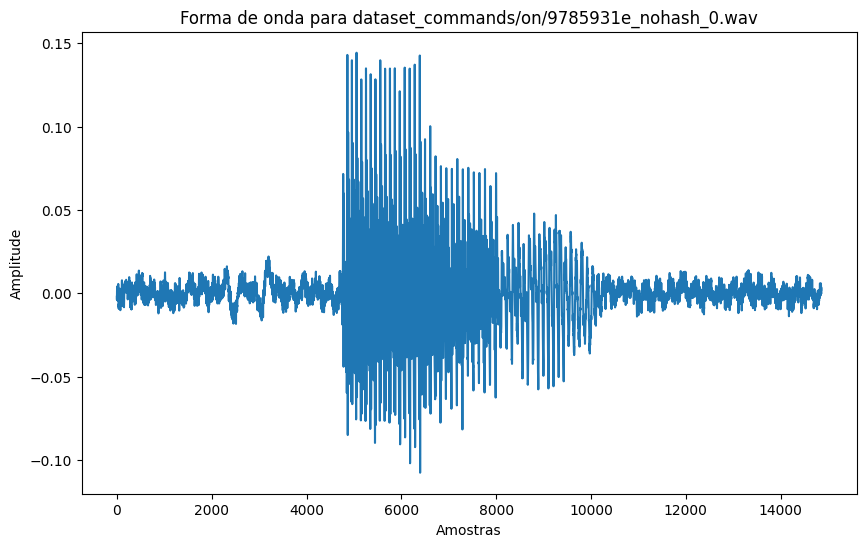

In [9]:
plt.figure(figsize=(10,6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {example_audio_path}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

In [10]:
from scipy.signal import resample

def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)

    def scipy_resample(wav, sample_rate):
        if sample_rate != 16000:
            wav = resample(wav, int(16000 / sample_rate * len(wav)))
        return wav

    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)

    audio_length = tf.shape(wav)[0]
    if audio_length > max_length:
        wav = wav[:max_length]
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, 'CONSTANT')

    return tf.reshape(wav, [max_length])

In [11]:
def process_path(file_path, label):
    audio = load_and_process_audio(file_path)
    return audio, label

In [12]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    audio_label_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return audio_label_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [14]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_audio_paths,
    all_labels_encoded,
    test_size=0.02,
    random_state=42,
    stratify=all_labels_encoded,
)

In [17]:
train_dataset = paths_and_labels_to_dataset(train_paths, train_labels)

In [18]:
val_dataset = paths_and_labels_to_dataset(val_paths, val_labels)

In [19]:
train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)

In [20]:
from tensorflow.keras import layers, models

In [21]:
model_time_domain = models.Sequential(
    [
        layers.Input(shape=(16_000, 1)),
        layers.Conv1D(16, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(36, activation='softmax'),
    ]
)

In [22]:
model_time_domain.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
history_time_domain = model_time_domain.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


2025-08-30 12:40:45.470309: I external/local_xla/xla/service/service.cc:163] XLA service 0x7871d8004ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-30 12:40:45.470331: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-08-30 12:40:45.500950: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-30 12:40:45.618764: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91100
2025-08-30 12:40:45.645254: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-30 12:40:46.316814: I e

   7/3242 ━━━━━━━━━━━━━━━━━━━━ 1:10 22ms/step - accuracy: 0.0499 - loss: 3.6332

I0000 00:00:1756568448.612053   23904 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3239/3242 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1274 - loss: 3.1922

2025-08-30 12:41:57.324724: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_231', 12 bytes spill stores, 12 bytes spill loads



3242/3242 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1275 - loss: 3.1920

2025-08-30 12:42:00.527176: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_69', 12 bytes spill stores, 12 bytes spill loads



3242/3242 ━━━━━━━━━━━━━━━━━━━━ 76s 22ms/step - accuracy: 0.1762 - loss: 2.9603 - val_accuracy: 0.2683 - val_loss: 2.6369
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - accuracy: 0.2953 - loss: 2.4479 - val_accuracy: 0.2834 - val_loss: 2.5007
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - accuracy: 0.3685 - loss: 2.1594 - val_accuracy: 0.2853 - val_loss: 2.5589
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - accuracy: 0.4318 - loss: 1.9215 - val_accuracy: 0.2900 - val_loss: 2.6124
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - accuracy: 0.4900 - loss: 1.7128 - val_accuracy: 0.3212 - val_loss: 2.7211
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - accuracy: 0.5439 - loss: 1.5286 - val_accuracy: 0.3146 - val_loss: 2.9465
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 70s 21ms/step - accuracy: 0.5915 - loss: 1.3641 - val_accuracy: 0.2985 - val_loss: 3.1666
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 70s 21ms/step - accuracy: 0.6372 - loss: 1.20

In [24]:
def plot_history(history):
    # Resumo do histórico de precisão
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend(loc='lower right')

    # Resumo do histórico de perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

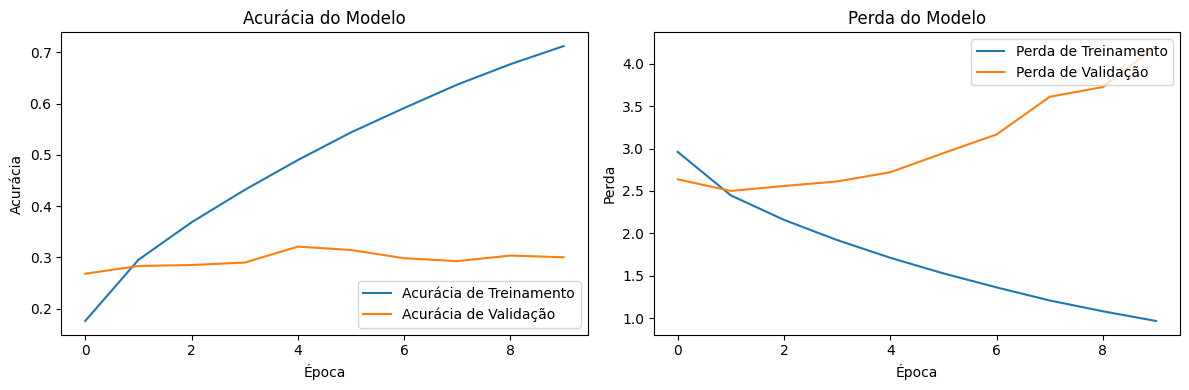

In [25]:
plot_history(history_time_domain)

In [26]:
def espectrograma(formadeonda):
    espect = tf.signal.stft(formadeonda, frame_length=255, frame_step=128)
    espect = tf.abs(espect)

    espect = espect[..., tf.newaxis]

    return espect

In [27]:
espect = espectrograma(audio.numpy())

In [28]:
def plota_espectrograma(espectrograma):
    if len(espectrograma.shape) > 2:
        assert len(espectrograma.shape) == 3
        espectrograma = np.squeeze(espectrograma, axis=-1)

    log_spec = np.log(espectrograma.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]

    X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
    Y = range(height)

    plt.pcolormesh(X, Y, log_spec)

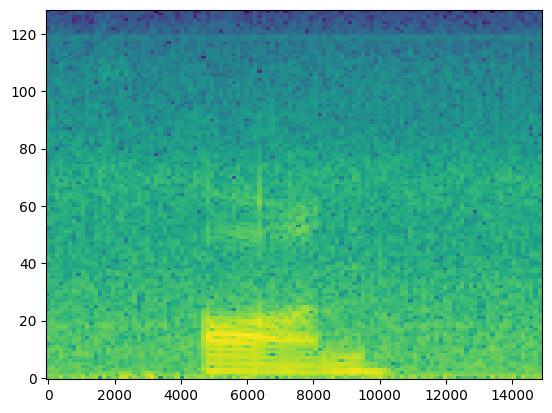

In [29]:
plota_espectrograma(espect)

In [61]:
def get_spectrogram_and_label_id(audio, label):
    espect = espectrograma(audio)
    return espect, label

In [62]:
train_spec = train_dataset.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)
val_spec = val_dataset.map(map_func=get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)

In [66]:
norm_layer = tf.keras.layers.Normalization()

for spectogram, _ in train_spec.take(1):
    norm_layer.adapt(spectogram)
    input_shape = spectogram.shape[1:]

In [67]:
num_labels = len(np.unique(all_labels))
num_labels

36

In [68]:
input_shape

TensorShape([124, 129, 1])

In [69]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

In [70]:
model_spectrogram.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [71]:
history_spectrogram = model_spectrogram.fit(train_spec, epochs=10, validation_data=val_spec)

Epoch 1/10


2025-08-30 13:06:19.423568: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-30 13:06:19.423595: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-30 13:06:20.132437: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1365', 68 bytes spill stores, 68 bytes spill loads

2025-08-30 13:06:20.255152: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

3242/3242 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.4615 - loss: 1.8758 - val_accuracy: 0.7407 - val_loss: 0.9393
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.6491 - loss: 1.1825 - val_accuracy: 0.7893 - val_loss: 0.7511
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.6995 - loss: 1.0101 - val_accuracy: 0.8214 - val_loss: 0.6253
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.7308 - loss: 0.8981 - val_accuracy: 0.8276 - val_loss: 0.5889
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.7509 - loss: 0.8266 - val_accuracy: 0.8337 - val_loss: 0.5661
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.7663 - loss: 0.7717 - val_accuracy: 0.8394 - val_loss: 0.5443
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.7784 - loss: 0.7269 - val_accuracy: 0.8451 - val_loss: 0.5334
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.7881 - loss: 0.6939 - va

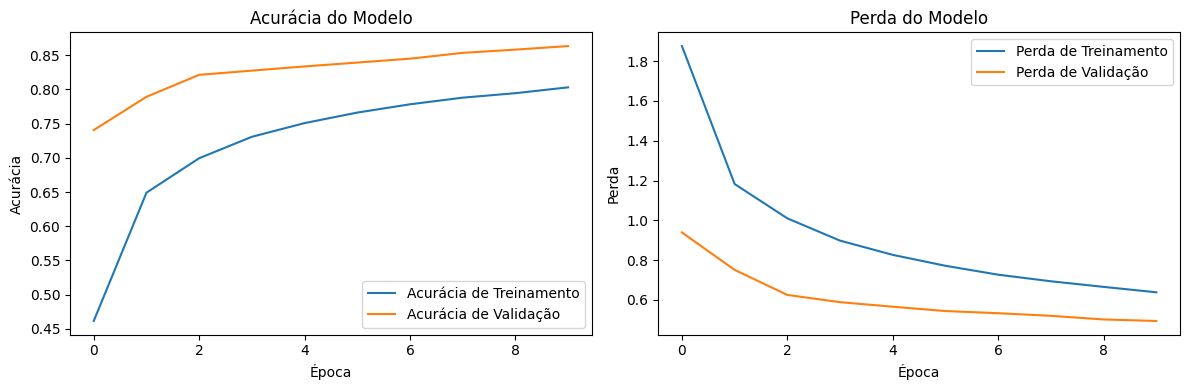

In [73]:
plot_history(history_spectrogram)

In [78]:
@tf.keras.utils.register_keras_serializable()
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.ratio = ratio
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()

    def build(self, input_shape):
        self.fc1 = layers.Dense(units=input_shape[-1]//self.ratio, activation='relu')
        self.fc2 = layers.Dense(units=input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        avg_out = self.avg_pool(inputs)
        max_out = self.max_pool(inputs)
        avg_out = self.fc2(self.fc1(avg_out))
        max_out = self.fc2(self.fc1(max_out))
        out = avg_out + max_out
        out = tf.expand_dims(tf.expand_dims(out, axis=1), axis=1)
        return inputs * out


In [79]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    ChannelAttention(ratio=8),
    layers.Conv2D(64, 3, activation='relu'),
    ChannelAttention(ratio=8),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

In [80]:
model_spectrogram.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

In [81]:
history_spectrogram = model_spectrogram.fit(train_spec, epochs=10, validation_data=val_spec)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.4915 - loss: 1.7576 - val_accuracy: 0.7600 - val_loss: 0.8451
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.6778 - loss: 1.0811 - val_accuracy: 0.7931 - val_loss: 0.7102
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.7252 - loss: 0.9086 - val_accuracy: 0.8455 - val_loss: 0.5447
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7552 - loss: 0.8063 - val_accuracy: 0.8588 - val_loss: 0.5167
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.7769 - loss: 0.7349 - val_accuracy: 0.8611 - val_loss: 0.4918
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.7941 - loss: 0.6786 - val_accuracy: 0.8588 - val_loss: 0.4668
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.8045 - loss: 0.6384 - val_accuracy: 0.8715 - val_loss: 0.4463
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.8124 - loss:

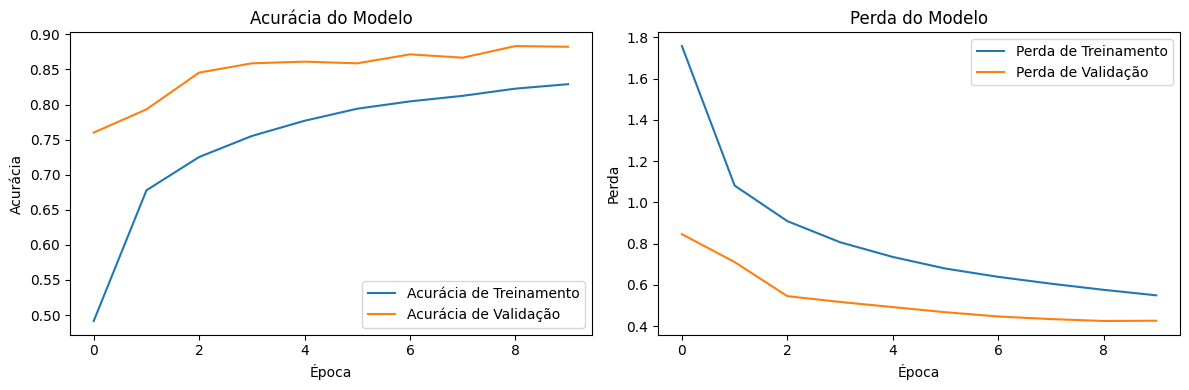

In [82]:
plot_history(history_spectrogram)

In [83]:
specific_audio_path = 'dados/yes.wav'

In [84]:
specific_audio = load_and_process_audio(specific_audio_path)

In [85]:
specific_spectrogram = espectrograma(specific_audio.numpy())

In [86]:
specific_spectrogram_batch = np.expand_dims(specific_spectrogram, axis=0)

In [88]:
specific_predition = model_spectrogram.predict(specific_spectrogram_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [91]:
specific_predition_label = np.argmax(specific_predition, axis=-1)[0]

In [93]:
label_encoder.inverse_transform([specific_predition_label])

array(['yes'], dtype='<U18')

In [94]:
model_spectrogram.save('model_spectrogram.keras')